# TigerGraph Graph Data Science Library 101 - Graph Embedding 

This notebook shows the examples of using graph embedding algorithms in TigerGraph Graph Science Library. More detailed explanations of these algorithms can be four in the official documentation 
(https://docs.tigergraph.com/graph-ml/current/node-embeddings/).  

## Step 1: Load Cora graph data

In [1]:
import json
config_file = open ('../config.json', "r")
config = json.load(config_file)
config_file.close()

In [2]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("Cora")

Downloading:   0%|          | 0/166537 [00:00<?, ?it/s]

In [3]:
from pyTigerGraph import TigerGraphConnection
import json

conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"],
)

In [4]:
conn.ingestDataset(dataset, getToken=config["getToken"])

---- Checking database ----
A graph with name Cora already exists in the database. Please drop it first before ingesting.


In [5]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Step 2: Running Louvain Community Detection
We are going to use the pyTigerGraph featurizer to run Louvain community detection on the citation network.

In [6]:
feat = conn.gds.featurizer()

params = {
    "v_type_set": "Paper",
    "e_type_set": "Cite",
    "weight_attr": "",
    "max_iter": 10,
    "result_attribute": "community_id",
    "file_path": "",
    "print_stats": True
}

feat.runAlgorithm("tg_louvain", params = params)

[{'AllVertexCount': 2708},
 {'InitChangeCount': 0},
 {'VertexFollowedToCommunity': 371},
 {'VertexFollowedToVertex': 114},
 {'VertexAssignedToItself': 0},
 {'FinalCommunityCount': 2280}]

## Step 3: Leveraging pyTigerGraph’s featurizer to run embedding algorithms

pyTIgerGraph provides a full suit of data science capabilities, and in this tutorial, we will showcase how to use featurizer to run a few popular algorithms as an example.

In [7]:
feat.listAlgorithms("Embeddings")

Available algorithms for Embeddings:
  FastRP:
    01. name: tg_fastRP
Call runAlgorithm() with the algorithm name to execute it


### Install and run fastRP algorithm 

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data. (https://docs.tigergraph.com/graph-ml/current/node-embeddings/fast-random-projection)

In [9]:
params={"v_type": ["Paper"],
        "e_type": ["Cite"],
        "output_v_type": ["Paper"],
        "iteration_weights": "1,2,4",
        "beta": -0.1,
        "embedding_dimension": 128,
        "embedding_dim_map": [],
        "default_length": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "component_attribute": "",
        "result_attribute": "embedding",
        "choose_k": 0}

feat.runAlgorithm("tg_fastRP", params=params)

[{'@@embedding_dim_map': {'default': {'min_dim': 0,
    'max_dim': 128,
    'weight': 1}}},
 {'sample_verts': []}]

In [10]:
df = conn.getVertexDataFrame("Paper")

In [11]:
df.head()

,v_id,id,x,y,train_mask,val_mask,test_mask,community_id,embedding
0,2571,2571,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,16777285,"[0.18001, -0.03698, 0.16291, -0.18522, -0.0242..."
1,2540,2540,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,26214414,"[0.05586, 0.17652, -0.00023, -0.21363, -0.1412..."
2,2514,2514,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,False,True,63963138,"[-0.18557, -0.14713, -0.09497, -0.19152, 0.470..."
3,2429,2429,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False,True,20971571,"[0, 0, 0, -0.25161, 0, -0.25161, 0, -0.25161, ..."
4,2306,2306,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,False,False,True,63963140,"[-0.27593, 0.35585, -0.52515, 0.00761, -0.0522..."


In [12]:
import pandas as pd

pd.DataFrame(df['community_id'].value_counts()).value_counts().sort_index()

community_id
1               1925
2                314
3                 29
4                  7
5                  3
12                 1
13                 1
dtype: int64

### Compute intra- and inter-communities similarities for FastRP embeddings using Louvain Communities

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cnt = 5
comms_list = ['community_id']

for comm in comms_list:
    print(f"***Community Detection ID: {comm}***\n")
    
    comm_embs = None
    print("Intra-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs = np.stack(community["embedding"].values)
        similarities = cosine_similarity(comm_embs)
        print(f"Community: {i}")
        print(f"Number of members in community: {len(comm_embs)}")
        print(f"Mean intra-community similarity: {similarities.mean()}")
        print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
        print()

    print("Inter-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs_comp = comm_embs
        comm_embs = np.stack(community["embedding"].values)

        if i >= 1:
            similarities = cosine_similarity(comm_embs_comp, comm_embs)
            print(f"Communities: {i-1}-{i}")
            print(f"Mean inter-community similarity: {similarities.mean()}")
            print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
            print()

***Community Detection ID: community_id***

Intra-community similarities:

Community: 0
Number of members in community: 13
Mean intra-community similarity: 0.995393532214212
Std. Dev. of intra-community similarity: 0.011322606612286857

Community: 1
Number of members in community: 12
Mean intra-community similarity: 0.9965355767565699
Std. Dev. of intra-community similarity: 0.008158297131735716

Community: 2
Number of members in community: 5
Mean intra-community similarity: 0.9884981291108721
Std. Dev. of intra-community similarity: 0.0167667139638064

Community: 3
Number of members in community: 5
Mean intra-community similarity: 0.9976103116344618
Std. Dev. of intra-community similarity: 0.0034835394757808343

Community: 4
Number of members in community: 5
Mean intra-community similarity: 0.9968358982217786
Std. Dev. of intra-community similarity: 0.004612431314800437

Inter-community similarities:

Communities: 0-1
Mean inter-community similarity: 0.10263887063503166
Std. Dev. of i

In [14]:
# Grab embeddings for Louvain Communities

c_id0 = df["community_id"].value_counts().head(25).index[0]
c_id1 = df["community_id"].value_counts().head(25).index[1]
c_id2 = df["community_id"].value_counts().head(25).index[2]
c_id3 = df["community_id"].value_counts().head(25).index[3]
c_id4 = df["community_id"].value_counts().head(25).index[4]

community0 = df[df["community_id"] == c_id0]
comm_embs0 = np.stack(community0["embedding"].values)

community1 = df[df["community_id"] == c_id1]
comm_embs1 = np.stack(community1["embedding"].values)

community2 = df[df["community_id"] == c_id2]
comm_embs2 = np.stack(community2["embedding"].values)

community3 = df[df["community_id"] == c_id3]
comm_embs3 = np.stack(community3["embedding"].values)

community4 = df[df["community_id"] == c_id4]
comm_embs4 = np.stack(community4["embedding"].values)

X = np.vstack((comm_embs0, comm_embs1, comm_embs2, comm_embs3, comm_embs4))

y0 = np.ones((comm_embs0.shape[0])) * 0
y1 = np.ones((comm_embs1.shape[0])) * 1
y2 = np.ones((comm_embs2.shape[0])) * 2
y3 = np.ones((comm_embs3.shape[0])) * 3
y4 = np.ones((comm_embs4.shape[0])) * 4
y = np.hstack((y0,y1,y2,y3,y4))

### Plot embeddings in 2D space

In [15]:
!pip install umap
!pip install umap-learn
!pip install seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=c0ce5734997b4be6dce065019e8f8d8193949b79880dcb7ed26046fd48e3f6c9
  Stored in directory: /home/tigergraph/.cache/pip/wheels/0f/d2/29/4d21dda3eb23f4eb42bc340a0e0282333539015afc8082a7b2
Successfully built umap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 47.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 38.6 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=44ab93997d96987ae5cdfe698d3ee8ecc6aebdbe9cfb6d07e1013d12ba579093
  Stored in directory: /home/tigergraph/.cache/pip/wheels/fb/99/10/ed2f3bc57ea29f540470eb43570

In [16]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(X)

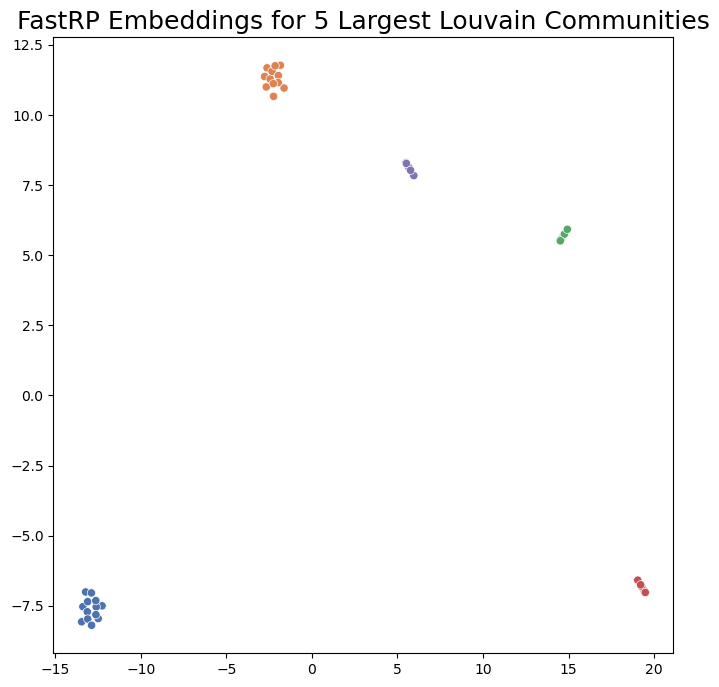

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2, 3, 4])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=y, palette=palette)
axs.get_legend().remove()
plt.title("FastRP Embeddings for 5 Largest Louvain Communities", fontsize=18)

plt.show()